# Analysis of Animal Shelter Data in Sonoma County, CA

## Goal of Analysis

Our main goal is to shed insight on the outcomes of animals surrendered to Sonoma County Animal Services.

## About the Data

In [19]:
!pip install catboost

  Using cached catboost-1.2-cp310-cp310-manylinux2014_x86_64.whl (98.6 MB)
  Using cached graphviz-0.20.1-py3-none-any.whl (47 kB)


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.metrics import confusion_matrix
from statsmodels.stats.outliers_influence import variance_inflation_factor
import random
random.seed(159)

In [2]:
shelter_data = pd.read_csv('./Animal_Shelter_Data.csv')
shelter_data.shape

(25008, 24)

In [3]:
shelter_data.head()

,Name,Type,Breed,Color,Sex,Size,Date Of Birth,Impound Number,Kennel Number,Animal ID,...,Intake Subtype,Outcome Type,Outcome Subtype,Intake Condition,Outcome Condition,Intake Jurisdiction,Outcome Jurisdiction,Outcome Zip Code,Location,Count
0,RAZOR,DOG,BOSTON TERRIER,BLACK/WHITE,Neutered,SMALL,10/29/2009,K22-043412,TRUCK,A396382,...,FIELD,RETURN TO OWNER,FLD_IDTAG,UNKNOWN,HEALTHY,SANTA ROSA,SANTA ROSA,95404.0,"95404(38.43807, -122.71247)",1
1,NaN,OTHER,PIGEON,GRAY/WHITE,Unknown,SMALL,NaN,K23-044095,TRUCK,A416206,...,FIELD,EUTHANIZE,INJ SEVERE,UNKNOWN,HEALTHY,SANTA ROSA,NaN,NaN,NaN,1
2,MAX,DOG,BORDER COLLIE,BLACK/TRICOLOR,Neutered,MED,03/10/2020,K23-044090,DS80,A399488,...,FIELD,RETURN TO OWNER,OVER THE COUNTER_CALL,UNKNOWN,PENDING,COUNTY,COUNTY,95472.0,"95472(38.40179, -122.82512)",1
3,NaN,CAT,DOMESTIC LH,GRAY/WHITE,Spayed,SMALL,06/26/2011,K22-043405,VET,A414520,...,FIELD,DISPOSAL,DOA,UNKNOWN,DEAD,COUNTY,SANTA ROSA,95403.0,"95403(38.51311, -122.75502)",1
4,PUDGY,DOG,CHIHUAHUA SH/SCHIPPERKE,TAN,Neutered,MED,07/20/2013,K23-043813,DA27,A415428,...,OVER THE COUNTER,TRANSFER,MUTTVILLE,UNKNOWN,HEALTHY,SANTA ROSA,OUT OF COUNTY,94103.0,"94103(37.77672, -122.40779)",1


In [4]:
shelter_data.columns

Index(['Name', 'Type', 'Breed', 'Color', 'Sex', 'Size', 'Date Of Birth',
       'Impound Number', 'Kennel Number', 'Animal ID', 'Intake Date',
       'Outcome Date', 'Days in Shelter', 'Intake Type', 'Intake Subtype',
       'Outcome Type', 'Outcome Subtype', 'Intake Condition',
       'Outcome Condition', 'Intake Jurisdiction', 'Outcome Jurisdiction',
       'Outcome Zip Code', 'Location', 'Count'],
      dtype='object')

### Data Cleaning

In [5]:
shelter_data.dropna(subset=['Size'], inplace=True)
shelter_data.isnull().sum()

Name                    6567
Type                       0
Breed                      0
Color                      0
Sex                        0
Size                       0
Date Of Birth           6206
Impound Number             0
Kennel Number             12
Animal ID                  0
Intake Date                0
Outcome Date             159
Days in Shelter            0
Intake Type                0
Intake Subtype             0
Outcome Type             165
Outcome Subtype          482
Intake Condition           0
Outcome Condition        508
Intake Jurisdiction        0
Outcome Jurisdiction    3508
Outcome Zip Code        3565
Location                3565
Count                      0
dtype: int64

In [6]:
shelter_data.rename(columns={'Intake Subtype': 'Intake_Subtype',
                            'Intake Type': 'Intake_Type',
                            'Intake Condition': 'Intake_Condition'}, inplace=True)

## Data Assumptions?

## Methods

### EDA

#### Explore the Number of Animals in the Shelter by Type

In [7]:
shelter_data.groupby('Intake_Type')['Type'].value_counts()

Intake_Type      Type 
ADOPTION RETURN  DOG        292
                 CAT        116
                 OTHER        4
BORN HERE        CAT         16
                 OTHER        1
CONFISCATE       DOG       1456
                 CAT        245
                 OTHER      197
OS APPT          DOG          1
OWNER SURRENDER  CAT       1595
                 DOG       1414
                 OTHER      143
QUARANTINE       DOG        424
                 OTHER      277
                 CAT        118
STRAY            DOG      10223
                 CAT       6603
                 OTHER     1417
TRANSFER         DOG        258
                 CAT        161
                 OTHER       12
Name: Type, dtype: int64

#### EDA: What are the Top Cat Breeds in the Shelter?

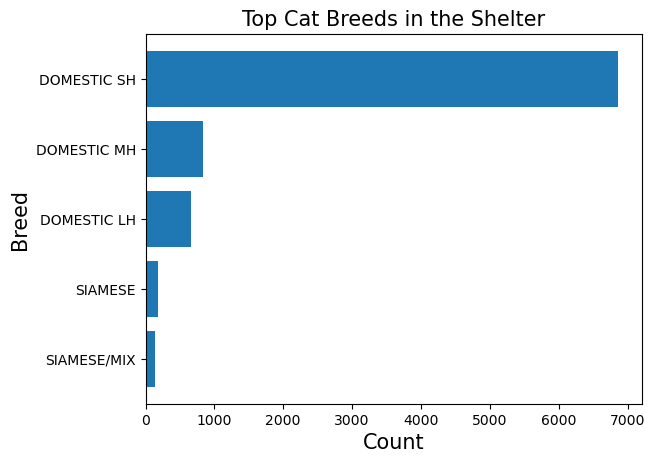

In [8]:
cat_data = shelter_data[shelter_data['Type'] == 'CAT']
cat_breed_counts = cat_data['Breed'].value_counts(ascending=True).tail(5)
plt.barh(cat_breed_counts.index, cat_breed_counts)
plt.title('Top Cat Breeds in the Shelter', size=15)
plt.xlabel('Count', size=15)
plt.ylabel('Breed', size=15)
plt.show()

#### EDA: What are the Top Dog Breeds in the Shelter?

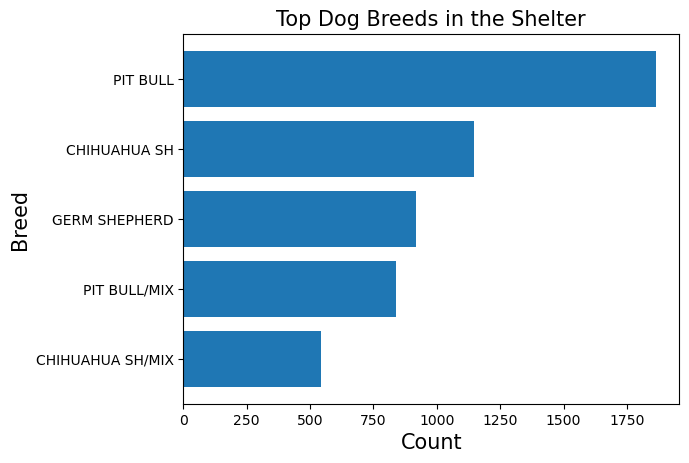

In [9]:
dog_data = shelter_data[shelter_data['Type'] == 'DOG']
dog_breed_counts = dog_data['Breed'].value_counts(ascending=True).tail(5)
plt.barh(dog_breed_counts.index, dog_breed_counts)
plt.title('Top Dog Breeds in the Shelter', size=15)
plt.xlabel('Count', size=15)
plt.ylabel('Breed', size=15)
plt.show()

#### Trend line: which year has the most number of animal intakes?

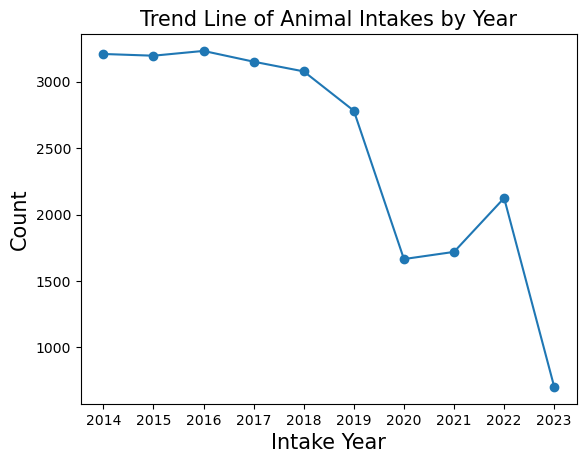

In [10]:
shelter_data['Intake Year'] = shelter_data['Intake Date'].apply(lambda x: x[-4:])

# Filter the data to only include records from the year 2014 and later.
shelter_data = shelter_data[shelter_data['Intake Year'] != '2013']
intake_counts = shelter_data.groupby('Intake Year').size()
intake_counts.plot(kind='line', title='Animal Intakes by Year')
plt.scatter(x=intake_counts.index, y=intake_counts)
plt.xticks(np.arange(len(intake_counts)), intake_counts.index)
plt.xlabel('Intake Year', size=15)
plt.ylabel('Count', size=15)
plt.title('Trend Line of Animal Intakes by Year', size=15)
plt.show()

### Modeling

#### Predict whether an Animal is adopted eventually

In [11]:
# Create a new column named Adopted, and assign a value of 0 or 1 
# to indicate whether each animal has been adopted or not.
shelter_data['Adopted'] = (shelter_data['Outcome Type'] == 'ADOPTION').astype(int)

#Split the data into test and train
shelter_train, shelter_test = train_test_split(shelter_data, test_size=0.3, random_state=159)
shelter_train.shape, shelter_test.shape

((17397, 26), (7456, 26))

In [12]:
import statsmodels.formula.api as smf
logreg = smf.logit(formula = 'Adopted ~ Type + Sex + Size + Intake_Type + Intake_Condition',
                       data = shelter_train).fit()
print(logreg.summary())

         Current function value: 0.351088
         Iterations: 35


/srv/conda/envs/notebook/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                           Logit Regression Results                           
Dep. Variable:                Adopted   No. Observations:                17397
Model:                          Logit   Df Residuals:                    17373
Method:                           MLE   Df Model:                           23
Date:                Sun, 07 May 2023   Pseudo R-squ.:                  0.4198
Time:                        04:11:39   Log-Likelihood:                -6107.9
converged:                      False   LL-Null:                       -10527.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                               coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
Intercept                                   -0.1241      0.211     -0.589      0.556      -0.537       0.289
Type[T.DOG]                              

In [13]:
# Predicting the probability of adopted
y_prob = logreg.predict(shelter_test)

# Predicting the label: 0 or 1?
y_pred = pd.Series([1 if x > 1/2 else 0 for x in y_prob], index=y_prob.index)

from sklearn.metrics import confusion_matrix
y_test = shelter_test['Adopted']
cm = confusion_matrix(y_test, y_pred)
print ("Confusion Matrix : \n", cm) 

Confusion Matrix : 
 [[4851  442]
 [ 842 1321]]


In [14]:
TN, FP, FN, TP = cm.ravel()

# What is the Accuracy?
acc= (TN + TP) / sum(cm.ravel())
print('Accuracy is: %.4f' %acc)


# What is the True Positive Rate ?
TPR_logit = TP/(TP+FN)
print('TPR is: %.4f' % TPR_logit)

# What is the False Positive rate ?
FPR_logit = FP/(FP+TN)
print('FPR is: %.4f' % FPR_logit)

Accuracy is: 0.8278
TPR is: 0.6107
FPR is: 0.0835


### Predicitng Days Before Adoption

In [68]:
adopted_all.columns

Index(['Name', 'Type', 'Breed', 'Color', 'Sex', 'Size', 'Date Of Birth',
       'Impound Number', 'Kennel Number', 'Animal ID', 'Intake Date',
       'Outcome Date', 'Days in Shelter', 'Intake_Type', 'Intake_Subtype',
       'Outcome Type', 'Outcome Subtype', 'Intake_Condition',
       'Outcome Condition', 'Intake Jurisdiction', 'Outcome Jurisdiction',
       'Outcome Zip Code', 'Location', 'Count', 'Intake Year', 'Adopted'],
      dtype='object')

In [75]:
### filtering on animals that are ultimately adopted
adopted_all = shelter_data[shelter_data['Outcome Type'] == 'ADOPTION']

### keeping only relevant columns
adopted = adopted_all[['Type', 'Breed', 'Color', 'Sex', 'Size', 'Date Of Birth', 'Intake Date','Days in Shelter', 
                       'Intake_Type', 'Intake_Subtype', 'Intake_Condition', 'Intake Jurisdiction', 'Location',
                      'Intake Year']]
adopted = adopted.reset_index(drop=True)

### creating a feature for animal age at intake time
adopted = adopted[~adopted['Date Of Birth'].isna()]
adopted = adopted.reset_index(drop=True)
adopted['age'] = (pd.to_datetime(adopted['Intake Date'], format='%m/%d/%Y') - pd.to_datetime(adopted['Date Of Birth'], 
                                                                                            format='%m/%d/%Y')).dt.days
adopted = adopted.drop(columns=['Intake Date', 'Date Of Birth'])
adopted = adopted.fillna('nan')

In [76]:
adopted['log_days'] = np.log1p(adopted['Days in Shelter'])

In [77]:
adopted_filtered = adopted[adopted['Days in Shelter']< 200]

In [78]:
### test train split
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

X_train, X_test, y_train, y_test = train_test_split(adopted_filtered.drop(['Days in Shelter', 'log_days'], axis=1), 
                                                    adopted_filtered['log_days'], test_size=0.2, random_state=42)

In [80]:
model = CatBoostRegressor(cat_features=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], loss_function='MAE', verbose=500,
                         depth=9, iterations=1500, learning_rate=0.05)
model.fit(X_train, y_train)
predictions = model.predict(X_test)

0:	learn: 0.6449894	total: 20.2ms	remaining: 30.3s
500:	learn: 0.3096699	total: 10.7s	remaining: 21.4s
1000:	learn: 0.2512172	total: 21.5s	remaining: 10.7s
1499:	learn: 0.2182771	total: 32.3s	remaining: 0us


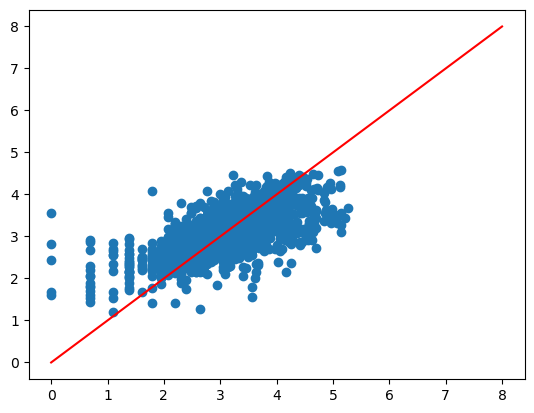

In [81]:
x = np.linspace(0, 8, 100)
y = x

plt.plot(x, y, color='red');
plt.scatter(x=y_test, y=predictions);
plt.show()

In [82]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

unlog_pred = np.expm1(predictions)
unlog_actual = np.expm1(y_test)

rmse = mean_squared_error(unlog_actual, unlog_pred, squared=False)
r2 = r2_score(unlog_actual, unlog_pred)

print("Testing performance")
print('RMSE: {:.2f}'.format(rmse))
print('R2: {:.2f}'.format(r2))

Testing performance
RMSE: 22.66
R2: 0.32


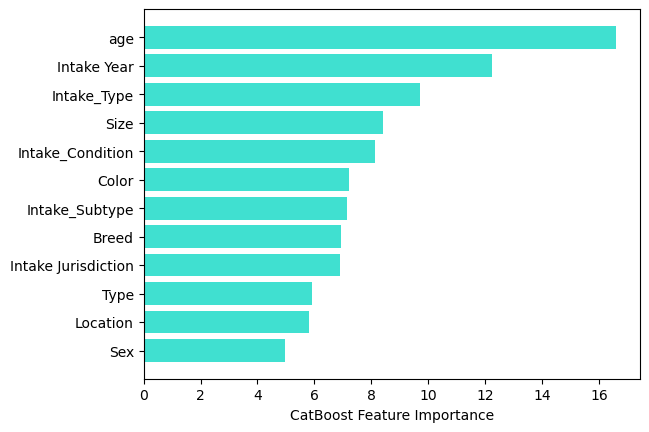

In [83]:
sorted_feature_importance = model.feature_importances_.argsort()
plt.barh(X_train.columns[sorted_feature_importance], 
        model.feature_importances_[sorted_feature_importance], 
        color='turquoise')
plt.xlabel("CatBoost Feature Importance");

## Results

## Conclusions

## Author Contributions